- Hatmap
- Melhorar o plot de imagens
- Propor algo novo

In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy 
import cv2
from torch.autograd import Variable
import random
import shutil, sys
import pandas as pd
from PIL import Image
from PIL import ImageFile
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = '/home/jimi/dissertacao/covid19/datasets/80-20/'

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
#model_name = "densenet"

# Number of classes in the dataset
#num_classes = 3

# Batch size for training (change depending on how much memory you have)
batch_size = 16

# Number of epochs to train for


# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

#num_epochs = 500

In [3]:
test = 2

In [48]:
# Data augmentation and normalization for training
# Just normalization for validation
#transforms.RandomRotation(degrees=(-5, 5)),
#transforms.ColorJitter(brightness=.02),
    
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) for x in ['train', 'val', 'test']}

# Create training and validation dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                    batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}

# trans = ['train','val','test']
# categories = ['train','val','test']

class_names = image_datasets['train'].classes

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#device.reset()

Initializing Datasets and Dataloaders...


In [49]:
# Path to data
data_dir = '/home/jimi/dissertacao/covid19/datasets/80-20/'
train_dir = data_dir+'train/'
test_dir = data_dir+'test/'
val_dir = data_dir+'val/'

normal_dir = data_dir+'normal/'
pneumonia_dir = data_dir+'pneumonia/'
covid_dir = data_dir+'covid/'

len_covid = len([iq for iq in os.scandir(normal_dir)])
len_normal = len([iq for iq in os.scandir(pneumonia_dir)])
len_pneumonia = len([iq for iq in os.scandir(covid_dir)])

len_train_dir = len([iq for iq in os.scandir(train_dir+'covid/')]) + len([iq for iq in os.scandir(train_dir+'normal/')]) + len([iq for iq in os.scandir(train_dir+'pneumonia/')])
len_test_dir = len([iq for iq in os.scandir(test_dir+'covid/')]) + len([iq for iq in os.scandir(test_dir+'normal/')]) + len([iq for iq in os.scandir(test_dir+'pneumonia/')])
len_val_dir = len([iq for iq in os.scandir(val_dir+'covid/')]) + len([iq for iq in os.scandir(val_dir+'normal/')]) + len([iq for iq in os.scandir(val_dir+'pneumonia/')])

print('Files per classes')
print("----"*10)
print("normal : ", len_covid)

print("pneumonia : ", len_normal)

print("covid : ", len_pneumonia)

print("-"*20)

print('Train, test, validation')

print("-"*20)

print("len_train_dir : ", len_train_dir)

print("len_test_dir : ", len_test_dir)

print("len_val_dir : ", len_val_dir)



Files per classes
----------------------------------------
normal :  4023
pneumonia :  4035
covid :  4105
--------------------
Train, test, validation
--------------------
len_train_dir :  9632
len_test_dir :  31
len_val_dir :  2409


In [50]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, model_name, lr, batch_size):
    since = time.time()
    is_inception = False
    
    #tensorboard
    writer = SummaryWriter(f'runs/dg_{model_name}_lr={lr}_epoch={num_epochs}_batch_size={batch_size}')
    step = 0

    val_acc_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        
        print('-' * 10)
        

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            

            writer.add_scalar('training loss', loss, global_step=step)
            writer.add_scalar('training accuracy', epoch_acc, global_step=step)
            step += 1
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)

        print()
        
        
    time_elapsed = time.time() - since
    print()

    print('#'*30)

    print('------ Summary ------')

    print(f'model -> {_model}')

    print(f'epochs -> {_epochs}')

    print(f'lr -> {_lrs}')

    print(f'batch size -> {_batch}')

    print()

    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val Acc: {:4f}'.format(best_acc))

    print('#'*30)
    
    plt.figure(figsize=(13, 4))
    plt.subplot(1, 2, 1)
    plt.plot(val_acc_history, label="Validation_Accuracy")
    plt.plot(val_loss_history, label="Validation_Loss")
    plt.title('Accuracy and Loss in Validation Dataset')
    plt.legend()
#     plt.subplot(1, 2, 2)
#     plt.plot(loss, label="loss")
#     plt.plot(phase, label="phase")
#     plt.legend()
    plt.tight_layout()
    plt.savefig('hist_'+_model+'.png')
    plt.show()

    print()

    print('==== END ====')


    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [51]:
def visualize_model(model, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 3, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [52]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [53]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size


In [54]:
import itertools 

def plot_confusion_matrix(cm, classes, net,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('cm_'+net+'.png')






==== INITIALIZING WITH PARAMETERS: ====
model -> squeezenet
epochs -> 300
lr -> 0.0001
batch size -> 8

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/299
----------
train Loss: 0.5270 Acc: 0.8083
val Loss: 0.3153 Acc: 0.9049

Epoch 1/299
----------
train Loss: 0.3022 Acc: 0.9069
val Loss: 0.2393 Acc: 0.9348

Epoch 2/299
----------
train Loss: 0.2558 Acc: 0.9141
val Loss: 0.2063 Acc: 0.9444

Epoch 3/299
----------
train Loss: 0.2330 Acc: 0.9263
val Loss: 0.1941 Acc: 0.9477

Epoch 4/299
----------
train Loss: 0.2163 Acc: 0.9287
val Loss: 0.1923 Acc: 0.9435

Epoch 5/299
----------
train Loss: 0.2055 Acc: 0.9338
val Loss: 0.1700 Acc: 0.9489

Epoch 6/299
----------
train Loss: 0.1945 Acc: 0.9378
val Loss: 0.1634 Acc: 0.9539

Epoch 7/299
----------
train Loss: 0.1876 Acc: 0.9372
val Loss: 0.1564 Acc: 0.9543

Epoch 8/299
----------
train Loss: 0.1830 Acc: 0.9387
val Loss: 0.1582 Acc: 0.9523

Epoch 9/299
----------


train Loss: 0.1153 Acc: 0.9605
val Loss: 0.0918 Acc: 0.9714

Epoch 94/299
----------
train Loss: 0.1113 Acc: 0.9610
val Loss: 0.0888 Acc: 0.9714

Epoch 95/299
----------
train Loss: 0.1147 Acc: 0.9588
val Loss: 0.0897 Acc: 0.9730

Epoch 96/299
----------
train Loss: 0.1118 Acc: 0.9612
val Loss: 0.0912 Acc: 0.9738

Epoch 97/299
----------
train Loss: 0.1121 Acc: 0.9622
val Loss: 0.0889 Acc: 0.9714

Epoch 98/299
----------
train Loss: 0.1132 Acc: 0.9608
val Loss: 0.0925 Acc: 0.9685

Epoch 99/299
----------
train Loss: 0.1113 Acc: 0.9614
val Loss: 0.0895 Acc: 0.9747

Epoch 100/299
----------
train Loss: 0.1164 Acc: 0.9600
val Loss: 0.0878 Acc: 0.9726

Epoch 101/299
----------
train Loss: 0.1109 Acc: 0.9621
val Loss: 0.0895 Acc: 0.9701

Epoch 102/299
----------
train Loss: 0.1113 Acc: 0.9617
val Loss: 0.0882 Acc: 0.9730

Epoch 103/299
----------
train Loss: 0.1140 Acc: 0.9603
val Loss: 0.0879 Acc: 0.9722

Epoch 104/299
----------
train Loss: 0.1136 Acc: 0.9617
val Loss: 0.0911 Acc: 0.9705


val Loss: 0.0810 Acc: 0.9718

Epoch 189/299
----------
train Loss: 0.0999 Acc: 0.9644
val Loss: 0.0815 Acc: 0.9730

Epoch 190/299
----------
train Loss: 0.1005 Acc: 0.9641
val Loss: 0.0806 Acc: 0.9734

Epoch 191/299
----------
train Loss: 0.1032 Acc: 0.9639
val Loss: 0.0807 Acc: 0.9759

Epoch 192/299
----------
train Loss: 0.1026 Acc: 0.9629
val Loss: 0.0798 Acc: 0.9747

Epoch 193/299
----------
train Loss: 0.1006 Acc: 0.9648
val Loss: 0.0840 Acc: 0.9697

Epoch 194/299
----------
train Loss: 0.1032 Acc: 0.9630
val Loss: 0.0899 Acc: 0.9672

Epoch 195/299
----------
train Loss: 0.1008 Acc: 0.9628
val Loss: 0.0802 Acc: 0.9747

Epoch 196/299
----------
train Loss: 0.1007 Acc: 0.9655
val Loss: 0.0850 Acc: 0.9697

Epoch 197/299
----------
train Loss: 0.1029 Acc: 0.9645
val Loss: 0.0796 Acc: 0.9755

Epoch 198/299
----------
train Loss: 0.1016 Acc: 0.9635
val Loss: 0.0803 Acc: 0.9776

Epoch 199/299
----------
train Loss: 0.1010 Acc: 0.9640
val Loss: 0.0829 Acc: 0.9751

Epoch 200/299
----------

train Loss: 0.0989 Acc: 0.9659
val Loss: 0.0793 Acc: 0.9722

Epoch 285/299
----------
train Loss: 0.0979 Acc: 0.9645
val Loss: 0.0757 Acc: 0.9751

Epoch 286/299
----------
train Loss: 0.0987 Acc: 0.9665
val Loss: 0.0756 Acc: 0.9772

Epoch 287/299
----------
train Loss: 0.0942 Acc: 0.9646
val Loss: 0.0831 Acc: 0.9689

Epoch 288/299
----------
train Loss: 0.0972 Acc: 0.9655
val Loss: 0.0758 Acc: 0.9755

Epoch 289/299
----------
train Loss: 0.0971 Acc: 0.9667
val Loss: 0.0806 Acc: 0.9709

Epoch 290/299
----------
train Loss: 0.0926 Acc: 0.9664
val Loss: 0.0773 Acc: 0.9747

Epoch 291/299
----------
train Loss: 0.0956 Acc: 0.9667
val Loss: 0.0803 Acc: 0.9718

Epoch 292/299
----------
train Loss: 0.0937 Acc: 0.9675
val Loss: 0.0768 Acc: 0.9784

Epoch 293/299
----------
train Loss: 0.0948 Acc: 0.9654
val Loss: 0.0760 Acc: 0.9768

Epoch 294/299
----------
train Loss: 0.0977 Acc: 0.9667
val Loss: 0.0775 Acc: 0.9747

Epoch 295/299
----------
train Loss: 0.0946 Acc: 0.9664
val Loss: 0.0802 Acc: 0

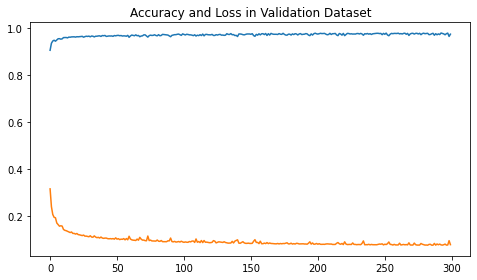


==== END ====
[[791   0   0]
 [  1 772  26]
 [  4  21 794]]

Sensitivity or recall total
0.9784142797841427

Sensitivity or recall per classes
[1.   0.97 0.97]

Precision
[0.99 0.97 0.97]

F1 Score
[1.   0.97 0.97]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> densenet
epochs -> 300
lr -> 0.0001
batch size -> 8

--------------------
Params to learn:
	 classifier.weight
	 classifier.bias

--------------------

== Epochs ==
Epoch 0/299
----------
train Loss: 0.6390 Acc: 0.8184
val Loss: 0.3793 Acc: 0.9348

Epoch 1/299
----------
train Loss: 0.3661 Acc: 0.9107
val Loss: 0.2782 Acc: 0.9435

Epoch 2/299
----------
train Loss: 0.2942 Acc: 0.9196
val Loss: 0.2281 Acc: 0.9485

Epoch 3/299
----------
train Loss: 0.2666 Acc: 0.9224
val Loss: 0.2081 Acc: 0.9494

Epoch 4/299
----------
train Loss: 0.2500 Acc: 0.9250
val Loss: 0.1917 Acc: 0.9514

Epoch 5/299
----------
train Loss: 0.2300 Acc: 0.9316
val Loss: 0.1805 Acc: 0.9523

Epoch 6/299
----------
tr

train Loss: 0.1284 Acc: 0.9532
val Loss: 0.0900 Acc: 0.9685

Epoch 91/299
----------
train Loss: 0.1331 Acc: 0.9528
val Loss: 0.0891 Acc: 0.9676

Epoch 92/299
----------
train Loss: 0.1282 Acc: 0.9530
val Loss: 0.0941 Acc: 0.9685

Epoch 93/299
----------
train Loss: 0.1298 Acc: 0.9526
val Loss: 0.0910 Acc: 0.9660

Epoch 94/299
----------
train Loss: 0.1242 Acc: 0.9564
val Loss: 0.0891 Acc: 0.9685

Epoch 95/299
----------
train Loss: 0.1286 Acc: 0.9538
val Loss: 0.0888 Acc: 0.9685

Epoch 96/299
----------
train Loss: 0.1306 Acc: 0.9541
val Loss: 0.0890 Acc: 0.9672

Epoch 97/299
----------
train Loss: 0.1248 Acc: 0.9546
val Loss: 0.0900 Acc: 0.9709

Epoch 98/299
----------
train Loss: 0.1262 Acc: 0.9535
val Loss: 0.0898 Acc: 0.9709

Epoch 99/299
----------
train Loss: 0.1249 Acc: 0.9558
val Loss: 0.0890 Acc: 0.9655

Epoch 100/299
----------
train Loss: 0.1262 Acc: 0.9544
val Loss: 0.0896 Acc: 0.9693

Epoch 101/299
----------
train Loss: 0.1228 Acc: 0.9559
val Loss: 0.0921 Acc: 0.9680

Ep

train Loss: 0.1133 Acc: 0.9598
val Loss: 0.0972 Acc: 0.9643

Epoch 187/299
----------
train Loss: 0.1106 Acc: 0.9587
val Loss: 0.0844 Acc: 0.9689

Epoch 188/299
----------
train Loss: 0.1185 Acc: 0.9576
val Loss: 0.0833 Acc: 0.9689

Epoch 189/299
----------
train Loss: 0.1133 Acc: 0.9589
val Loss: 0.0855 Acc: 0.9685

Epoch 190/299
----------
train Loss: 0.1124 Acc: 0.9591
val Loss: 0.0841 Acc: 0.9689

Epoch 191/299
----------
train Loss: 0.1209 Acc: 0.9570
val Loss: 0.0862 Acc: 0.9693

Epoch 192/299
----------
train Loss: 0.1168 Acc: 0.9575
val Loss: 0.0862 Acc: 0.9672

Epoch 193/299
----------
train Loss: 0.1164 Acc: 0.9559
val Loss: 0.0881 Acc: 0.9705

Epoch 194/299
----------
train Loss: 0.1125 Acc: 0.9578
val Loss: 0.0860 Acc: 0.9701

Epoch 195/299
----------
train Loss: 0.1149 Acc: 0.9575
val Loss: 0.0859 Acc: 0.9693

Epoch 196/299
----------
train Loss: 0.1158 Acc: 0.9577
val Loss: 0.0833 Acc: 0.9689

Epoch 197/299
----------
train Loss: 0.1176 Acc: 0.9560
val Loss: 0.0847 Acc: 0

val Loss: 0.0812 Acc: 0.9701

Epoch 282/299
----------
train Loss: 0.1023 Acc: 0.9642
val Loss: 0.0834 Acc: 0.9689

Epoch 283/299
----------
train Loss: 0.1136 Acc: 0.9601
val Loss: 0.0806 Acc: 0.9726

Epoch 284/299
----------
train Loss: 0.1109 Acc: 0.9607
val Loss: 0.0781 Acc: 0.9718

Epoch 285/299
----------
train Loss: 0.1143 Acc: 0.9575
val Loss: 0.0812 Acc: 0.9734

Epoch 286/299
----------
train Loss: 0.1106 Acc: 0.9577
val Loss: 0.0824 Acc: 0.9685

Epoch 287/299
----------
train Loss: 0.1114 Acc: 0.9599
val Loss: 0.0801 Acc: 0.9722

Epoch 288/299
----------
train Loss: 0.1100 Acc: 0.9570
val Loss: 0.0796 Acc: 0.9709

Epoch 289/299
----------
train Loss: 0.1115 Acc: 0.9587
val Loss: 0.0814 Acc: 0.9709

Epoch 290/299
----------
train Loss: 0.1141 Acc: 0.9594
val Loss: 0.0828 Acc: 0.9685

Epoch 291/299
----------
train Loss: 0.1135 Acc: 0.9585
val Loss: 0.0818 Acc: 0.9709

Epoch 292/299
----------
train Loss: 0.1141 Acc: 0.9575
val Loss: 0.0794 Acc: 0.9726

Epoch 293/299
----------

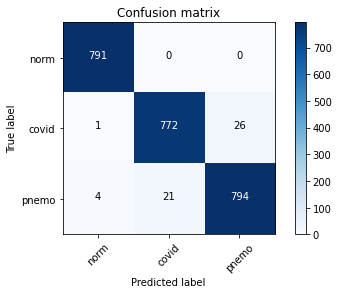

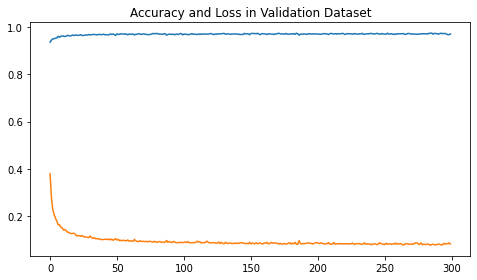


==== END ====
[[790   0   1]
 [  0 768  31]
 [  0  32 787]]

Sensitivity or recall total
0.9734329597343296

Sensitivity or recall per classes
[1.   0.96 0.96]

Precision
[1.   0.96 0.96]

F1 Score
[1.   0.96 0.96]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> resnet
epochs -> 300
lr -> 0.0001
batch size -> 8

--------------------
Params to learn:
	 fc.weight
	 fc.bias

--------------------

== Epochs ==
Epoch 0/299
----------
train Loss: 0.6510 Acc: 0.7821
val Loss: 0.4019 Acc: 0.9058

Epoch 1/299
----------
train Loss: 0.3823 Acc: 0.8952
val Loss: 0.3127 Acc: 0.9070

Epoch 2/299
----------
train Loss: 0.3175 Acc: 0.9038
val Loss: 0.2592 Acc: 0.9199

Epoch 3/299
----------
train Loss: 0.2915 Acc: 0.9105
val Loss: 0.2629 Acc: 0.9182

Epoch 4/299
----------
train Loss: 0.2698 Acc: 0.9155
val Loss: 0.2513 Acc: 0.9116

Epoch 5/299
----------
train Loss: 0.2536 Acc: 0.9196
val Loss: 0.1956 Acc: 0.9402

Epoch 6/299
----------
train Loss: 0.2437 A

val Loss: 0.1563 Acc: 0.9398

Epoch 91/299
----------
train Loss: 0.1474 Acc: 0.9467
val Loss: 0.1105 Acc: 0.9572

Epoch 92/299
----------
train Loss: 0.1464 Acc: 0.9460
val Loss: 0.1253 Acc: 0.9539

Epoch 93/299
----------
train Loss: 0.1431 Acc: 0.9459
val Loss: 0.1188 Acc: 0.9527

Epoch 94/299
----------
train Loss: 0.1514 Acc: 0.9451
val Loss: 0.1117 Acc: 0.9572

Epoch 95/299
----------
train Loss: 0.1521 Acc: 0.9414
val Loss: 0.1177 Acc: 0.9539

Epoch 96/299
----------
train Loss: 0.1451 Acc: 0.9465
val Loss: 0.1131 Acc: 0.9581

Epoch 97/299
----------
train Loss: 0.1459 Acc: 0.9454
val Loss: 0.1141 Acc: 0.9593

Epoch 98/299
----------
train Loss: 0.1402 Acc: 0.9487
val Loss: 0.1087 Acc: 0.9593

Epoch 99/299
----------
train Loss: 0.1521 Acc: 0.9429
val Loss: 0.1083 Acc: 0.9601

Epoch 100/299
----------
train Loss: 0.1460 Acc: 0.9458
val Loss: 0.1628 Acc: 0.9361

Epoch 101/299
----------
train Loss: 0.1421 Acc: 0.9487
val Loss: 0.1556 Acc: 0.9386

Epoch 102/299
----------
train Lo

train Loss: 0.1336 Acc: 0.9486
val Loss: 0.1168 Acc: 0.9543

Epoch 187/299
----------
train Loss: 0.1332 Acc: 0.9516
val Loss: 0.1106 Acc: 0.9572

Epoch 188/299
----------
train Loss: 0.1323 Acc: 0.9504
val Loss: 0.1149 Acc: 0.9527

Epoch 189/299
----------
train Loss: 0.1363 Acc: 0.9496
val Loss: 0.1106 Acc: 0.9581

Epoch 190/299
----------
train Loss: 0.1378 Acc: 0.9493
val Loss: 0.1517 Acc: 0.9402

Epoch 191/299
----------
train Loss: 0.1320 Acc: 0.9511
val Loss: 0.1085 Acc: 0.9556

Epoch 192/299
----------
train Loss: 0.1339 Acc: 0.9494
val Loss: 0.1023 Acc: 0.9610

Epoch 193/299
----------
train Loss: 0.1359 Acc: 0.9494
val Loss: 0.1071 Acc: 0.9564

Epoch 194/299
----------
train Loss: 0.1309 Acc: 0.9530
val Loss: 0.1047 Acc: 0.9589

Epoch 195/299
----------
train Loss: 0.1359 Acc: 0.9502
val Loss: 0.1167 Acc: 0.9527

Epoch 196/299
----------
train Loss: 0.1301 Acc: 0.9523
val Loss: 0.1895 Acc: 0.9220

Epoch 197/299
----------
train Loss: 0.1342 Acc: 0.9509
val Loss: 0.1201 Acc: 0

val Loss: 0.1029 Acc: 0.9618

Epoch 282/299
----------
train Loss: 0.1262 Acc: 0.9505
val Loss: 0.1043 Acc: 0.9585

Epoch 283/299
----------
train Loss: 0.1180 Acc: 0.9582
val Loss: 0.1074 Acc: 0.9552

Epoch 284/299
----------
train Loss: 0.1192 Acc: 0.9550
val Loss: 0.1060 Acc: 0.9606

Epoch 285/299
----------
train Loss: 0.1280 Acc: 0.9523
val Loss: 0.1161 Acc: 0.9518

Epoch 286/299
----------
train Loss: 0.1269 Acc: 0.9529
val Loss: 0.1394 Acc: 0.9448

Epoch 287/299
----------
train Loss: 0.1255 Acc: 0.9527
val Loss: 0.1825 Acc: 0.9261

Epoch 288/299
----------
train Loss: 0.1290 Acc: 0.9540
val Loss: 0.1088 Acc: 0.9552

Epoch 289/299
----------
train Loss: 0.1261 Acc: 0.9534
val Loss: 0.1683 Acc: 0.9332

Epoch 290/299
----------
train Loss: 0.1321 Acc: 0.9521
val Loss: 0.1342 Acc: 0.9465

Epoch 291/299
----------
train Loss: 0.1240 Acc: 0.9520
val Loss: 0.1095 Acc: 0.9556

Epoch 292/299
----------
train Loss: 0.1305 Acc: 0.9521
val Loss: 0.1042 Acc: 0.9601

Epoch 293/299
----------

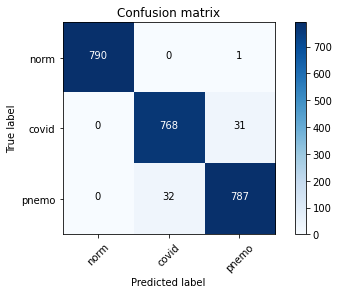

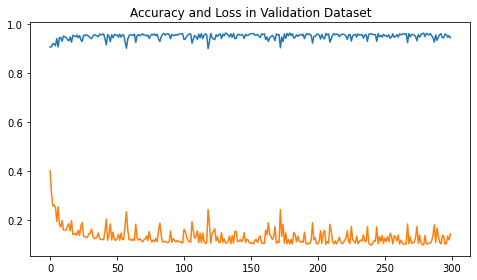


==== END ====
[[790   0   1]
 [  1 775  23]
 [  4  60 755]]

Sensitivity or recall total
0.9630552096305521

Sensitivity or recall per classes
[1.   0.97 0.92]

Precision
[0.99 0.93 0.97]

F1 Score
[1.   0.95 0.94]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> alexnet
epochs -> 300
lr -> 0.0001
batch size -> 8

--------------------
Params to learn:
	 classifier.6.weight
	 classifier.6.bias

--------------------

== Epochs ==
Epoch 0/299
----------
train Loss: 0.4494 Acc: 0.8309
val Loss: 0.2855 Acc: 0.9045

Epoch 1/299
----------
train Loss: 0.3393 Acc: 0.8718
val Loss: 0.2370 Acc: 0.9215

Epoch 2/299
----------
train Loss: 0.3070 Acc: 0.8850
val Loss: 0.2455 Acc: 0.9137

Epoch 3/299
----------
train Loss: 0.2995 Acc: 0.8850
val Loss: 0.2242 Acc: 0.9203

Epoch 4/299
----------
train Loss: 0.2916 Acc: 0.8906
val Loss: 0.2128 Acc: 0.9282

Epoch 5/299
----------
train Loss: 0.2803 Acc: 0.8921
val Loss: 0.2155 Acc: 0.9207

Epoch 6/299
----------

train Loss: 0.2276 Acc: 0.9139
val Loss: 0.1727 Acc: 0.9365

Epoch 91/299
----------
train Loss: 0.2262 Acc: 0.9125
val Loss: 0.1631 Acc: 0.9411

Epoch 92/299
----------
train Loss: 0.2205 Acc: 0.9168
val Loss: 0.1596 Acc: 0.9440

Epoch 93/299
----------
train Loss: 0.2305 Acc: 0.9101
val Loss: 0.1638 Acc: 0.9394

Epoch 94/299
----------
train Loss: 0.2246 Acc: 0.9150
val Loss: 0.1527 Acc: 0.9473

Epoch 95/299
----------
train Loss: 0.2278 Acc: 0.9155
val Loss: 0.1777 Acc: 0.9340

Epoch 96/299
----------
train Loss: 0.2284 Acc: 0.9163
val Loss: 0.1581 Acc: 0.9440

Epoch 97/299
----------
train Loss: 0.2239 Acc: 0.9172
val Loss: 0.1453 Acc: 0.9473

Epoch 98/299
----------
train Loss: 0.2324 Acc: 0.9103
val Loss: 0.1657 Acc: 0.9381

Epoch 99/299
----------
train Loss: 0.2289 Acc: 0.9129
val Loss: 0.1532 Acc: 0.9440

Epoch 100/299
----------
train Loss: 0.2173 Acc: 0.9193
val Loss: 0.1766 Acc: 0.9352

Epoch 101/299
----------
train Loss: 0.2255 Acc: 0.9156
val Loss: 0.1906 Acc: 0.9265

Ep

train Loss: 0.2136 Acc: 0.9189
val Loss: 0.1437 Acc: 0.9477

Epoch 187/299
----------
train Loss: 0.2252 Acc: 0.9128
val Loss: 0.1418 Acc: 0.9481

Epoch 188/299
----------
train Loss: 0.2127 Acc: 0.9188
val Loss: 0.1586 Acc: 0.9427

Epoch 189/299
----------
train Loss: 0.2255 Acc: 0.9143
val Loss: 0.1450 Acc: 0.9514

Epoch 190/299
----------
train Loss: 0.2203 Acc: 0.9164
val Loss: 0.1712 Acc: 0.9344

Epoch 191/299
----------
train Loss: 0.2176 Acc: 0.9167
val Loss: 0.1580 Acc: 0.9419

Epoch 192/299
----------
train Loss: 0.2198 Acc: 0.9157
val Loss: 0.1453 Acc: 0.9489

Epoch 193/299
----------
train Loss: 0.2130 Acc: 0.9199
val Loss: 0.1454 Acc: 0.9494

Epoch 194/299
----------
train Loss: 0.2209 Acc: 0.9154
val Loss: 0.1547 Acc: 0.9431

Epoch 195/299
----------
train Loss: 0.2223 Acc: 0.9152
val Loss: 0.1450 Acc: 0.9473

Epoch 196/299
----------
train Loss: 0.2256 Acc: 0.9163
val Loss: 0.1570 Acc: 0.9444

Epoch 197/299
----------
train Loss: 0.2265 Acc: 0.9148
val Loss: 0.1557 Acc: 0

val Loss: 0.1395 Acc: 0.9477

Epoch 282/299
----------
train Loss: 0.2124 Acc: 0.9213
val Loss: 0.1615 Acc: 0.9386

Epoch 283/299
----------
train Loss: 0.2183 Acc: 0.9191
val Loss: 0.1632 Acc: 0.9394

Epoch 284/299
----------
train Loss: 0.2101 Acc: 0.9225
val Loss: 0.1431 Acc: 0.9460

Epoch 285/299
----------
train Loss: 0.2200 Acc: 0.9149
val Loss: 0.1532 Acc: 0.9419

Epoch 286/299
----------
train Loss: 0.2165 Acc: 0.9185
val Loss: 0.1446 Acc: 0.9452

Epoch 287/299
----------
train Loss: 0.2194 Acc: 0.9162
val Loss: 0.1558 Acc: 0.9406

Epoch 288/299
----------
train Loss: 0.2213 Acc: 0.9162
val Loss: 0.1553 Acc: 0.9406

Epoch 289/299
----------
train Loss: 0.2142 Acc: 0.9169
val Loss: 0.1459 Acc: 0.9460

Epoch 290/299
----------
train Loss: 0.2175 Acc: 0.9154
val Loss: 0.1436 Acc: 0.9465

Epoch 291/299
----------
train Loss: 0.2133 Acc: 0.9203
val Loss: 0.1533 Acc: 0.9435

Epoch 292/299
----------
train Loss: 0.2181 Acc: 0.9161
val Loss: 0.1414 Acc: 0.9489

Epoch 293/299
----------

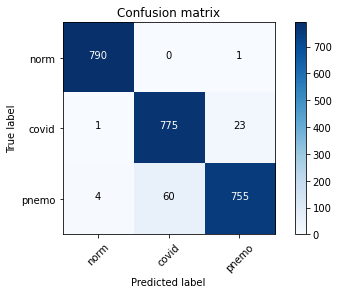

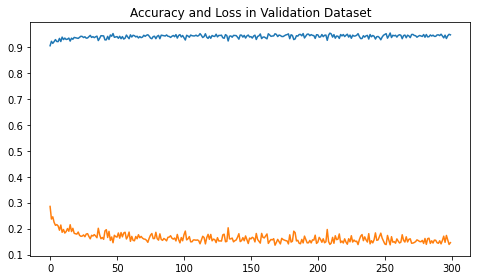


==== END ====
[[778   6   7]
 [  5 781  13]
 [  7  74 738]]

Sensitivity or recall total
0.9535076795350768

Sensitivity or recall per classes
[0.98 0.98 0.9 ]

Precision
[0.98 0.91 0.97]

F1 Score
[0.98 0.94 0.94]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> vgg
epochs -> 300
lr -> 0.0001
batch size -> 8

--------------------
Params to learn:
	 classifier.6.weight
	 classifier.6.bias

--------------------

== Epochs ==
Epoch 0/299
----------
train Loss: 0.5465 Acc: 0.8394
val Loss: 0.3144 Acc: 0.9315

Epoch 1/299
----------
train Loss: 0.3280 Acc: 0.9087
val Loss: 0.2464 Acc: 0.9369

Epoch 2/299
----------
train Loss: 0.2771 Acc: 0.9191
val Loss: 0.2156 Acc: 0.9411

Epoch 3/299
----------
train Loss: 0.2557 Acc: 0.9170
val Loss: 0.1973 Acc: 0.9431

Epoch 4/299
----------
train Loss: 0.2392 Acc: 0.9229
val Loss: 0.1798 Acc: 0.9448

Epoch 5/299
----------
train Loss: 0.2299 Acc: 0.9234
val Loss: 0.1818 Acc: 0.9460

Epoch 6/299
----------
tra

train Loss: 0.1557 Acc: 0.9433
val Loss: 0.1043 Acc: 0.9622

Epoch 91/299
----------
train Loss: 0.1567 Acc: 0.9410
val Loss: 0.1025 Acc: 0.9643

Epoch 92/299
----------
train Loss: 0.1528 Acc: 0.9439
val Loss: 0.1046 Acc: 0.9635

Epoch 93/299
----------
train Loss: 0.1525 Acc: 0.9445
val Loss: 0.0998 Acc: 0.9660

Epoch 94/299
----------
train Loss: 0.1521 Acc: 0.9456
val Loss: 0.1033 Acc: 0.9647

Epoch 95/299
----------
train Loss: 0.1547 Acc: 0.9419
val Loss: 0.0970 Acc: 0.9660

Epoch 96/299
----------
train Loss: 0.1563 Acc: 0.9425
val Loss: 0.1013 Acc: 0.9647

Epoch 97/299
----------
train Loss: 0.1563 Acc: 0.9411
val Loss: 0.1044 Acc: 0.9643

Epoch 98/299
----------
train Loss: 0.1549 Acc: 0.9435
val Loss: 0.1057 Acc: 0.9672

Epoch 99/299
----------
train Loss: 0.1542 Acc: 0.9430
val Loss: 0.0987 Acc: 0.9664

Epoch 100/299
----------
train Loss: 0.1556 Acc: 0.9451
val Loss: 0.1050 Acc: 0.9631

Epoch 101/299
----------
train Loss: 0.1569 Acc: 0.9400
val Loss: 0.1090 Acc: 0.9601

Ep

train Loss: 0.1431 Acc: 0.9461
val Loss: 0.0928 Acc: 0.9668

Epoch 187/299
----------
train Loss: 0.1447 Acc: 0.9459
val Loss: 0.0938 Acc: 0.9689

Epoch 188/299
----------
train Loss: 0.1465 Acc: 0.9460
val Loss: 0.0969 Acc: 0.9672

Epoch 189/299
----------
train Loss: 0.1443 Acc: 0.9466
val Loss: 0.0905 Acc: 0.9689

Epoch 190/299
----------
train Loss: 0.1401 Acc: 0.9490
val Loss: 0.0988 Acc: 0.9643

Epoch 191/299
----------
train Loss: 0.1479 Acc: 0.9465
val Loss: 0.0951 Acc: 0.9680

Epoch 192/299
----------
train Loss: 0.1421 Acc: 0.9465
val Loss: 0.0985 Acc: 0.9647

Epoch 193/299
----------
train Loss: 0.1442 Acc: 0.9466
val Loss: 0.0907 Acc: 0.9697

Epoch 194/299
----------
train Loss: 0.1457 Acc: 0.9468
val Loss: 0.0943 Acc: 0.9701

Epoch 195/299
----------
train Loss: 0.1437 Acc: 0.9481
val Loss: 0.0905 Acc: 0.9685

Epoch 196/299
----------
train Loss: 0.1420 Acc: 0.9472
val Loss: 0.0957 Acc: 0.9668

Epoch 197/299
----------
train Loss: 0.1435 Acc: 0.9454
val Loss: 0.0921 Acc: 0

val Loss: 0.0982 Acc: 0.9635

Epoch 282/299
----------
train Loss: 0.1320 Acc: 0.9510
val Loss: 0.0912 Acc: 0.9705

Epoch 283/299
----------
train Loss: 0.1361 Acc: 0.9496
val Loss: 0.0918 Acc: 0.9672

Epoch 284/299
----------
train Loss: 0.1385 Acc: 0.9477
val Loss: 0.0913 Acc: 0.9676

Epoch 285/299
----------
train Loss: 0.1428 Acc: 0.9475
val Loss: 0.0910 Acc: 0.9689

Epoch 286/299
----------
train Loss: 0.1368 Acc: 0.9484
val Loss: 0.0905 Acc: 0.9680

Epoch 287/299
----------
train Loss: 0.1356 Acc: 0.9488
val Loss: 0.0893 Acc: 0.9680

Epoch 288/299
----------
train Loss: 0.1422 Acc: 0.9467
val Loss: 0.0861 Acc: 0.9705

Epoch 289/299
----------
train Loss: 0.1377 Acc: 0.9495
val Loss: 0.0920 Acc: 0.9693

Epoch 290/299
----------
train Loss: 0.1429 Acc: 0.9445
val Loss: 0.0897 Acc: 0.9697

Epoch 291/299
----------
train Loss: 0.1378 Acc: 0.9462
val Loss: 0.0946 Acc: 0.9660

Epoch 292/299
----------
train Loss: 0.1445 Acc: 0.9436
val Loss: 0.0887 Acc: 0.9693

Epoch 293/299
----------

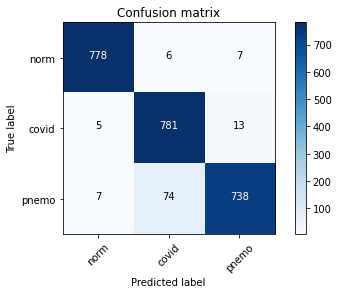

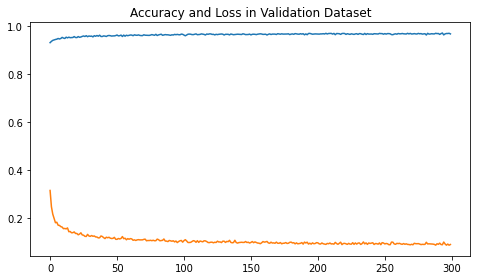


==== END ====
[[789   2   0]
 [  1 777  21]
 [  3  41 775]]

Sensitivity or recall total
0.9717725197177252

Sensitivity or recall per classes
[1.   0.97 0.95]

Precision
[0.99 0.95 0.97]

F1 Score
[1.   0.96 0.96]
Confusion matrix, without normalization


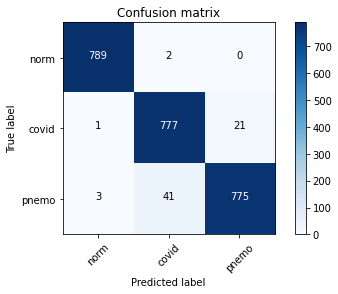

In [55]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
num_classes = 3

_models = ['squeezenet', 'densenet', 'resnet', 'alexnet', 'vgg']
lrs = [1e-4]
_epoch = [500]
batch_sizes = [8]

for _model in _models:
    for _epochs in _epoch:
        for _lrs in lrs:
            for _batch in batch_sizes:
                               
                print()

                print('='*60)

                print('==== INITIALIZING WITH PARAMETERS: ====')

                print(f'model -> {_model}')

                print(f'epochs -> {_epochs}')

                print(f'lr -> {_lrs}')

                print(f'batch size -> {_batch}')

                print()


                feature_extract = True
                
                model_ft, input_size = initialize_model(_model, num_classes, 
                                                        feature_extract, use_pretrained=True)
                
                # Send the model to GPU
                model_ft = model_ft.to(device)

                print('-'*20)
                params_to_update = model_ft.parameters()
                print("Params to learn:")
                if feature_extract:
                    params_to_update = []
                    for name,param in model_ft.named_parameters():
                        if param.requires_grad == True:
                            params_to_update.append(param)
                            print("\t",name)
                            
                else:
                    for name,param in model_ft.named_parameters():
                        if param.requires_grad == True:
                            print("\t",name)
                            

                print()
                
                print('-'*20)
                
                print()
                print('== Epochs ==')
                
                optimizer_ft = optim.SGD(params_to_update, _lrs, momentum=0.9)
                exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

                criterion = nn.CrossEntropyLoss()

                model_ft, hist = train_model(model_ft, dataloaders, criterion, optimizer_ft,
                                             num_epochs=_epochs, model_name=_model, lr=_lrs, batch_size=_batch)
                
                from sklearn.metrics import confusion_matrix

                nb_classes = 3

                # Initialize the prediction and label lists(tensors)
                predlist=torch.zeros(0,dtype=torch.long, device='cpu')
                lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

                with torch.no_grad():
                    for i, (inputs, classes) in enumerate(dataloaders['val']):
                        inputs = inputs.to(device) #labels atuais
                        classes = classes.to(device) #classes
                        outputs = model_ft(inputs) #valores preditos = Passa o label atual e retorna o que o modelo predice
                        _, preds = torch.max(outputs, 1) #pega o maior valor das predições

                        # Append batch prediction results
                        predlist=torch.cat([predlist,preds.view(-1).cpu()])
                        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

                # Confusion matrix
                conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
                print(conf_mat)
                print()
                
                from sklearn import metrics

                #analise dos resultados do modelo
                print('Sensitivity or recall total')
                print (metrics.recall_score(lbllist.numpy(), predlist.numpy(), average='micro'))

                print()
                print('Sensitivity or recall per classes')
                print (metrics.recall_score(lbllist.numpy(), predlist.numpy(), average=None))

                print()
                print('Precision')
                print (metrics.precision_score(lbllist.numpy(), predlist.numpy(), average=None))

                print()
                print('F1 Score')
                print (metrics.f1_score(lbllist.numpy(), predlist.numpy(), average=None))
                
                cm = confusion_matrix(lbllist.numpy(), predlist.numpy())
                np.set_printoptions(precision=2)

                plt.figure()

                plot_confusion_matrix(cm, classes=['norm', 'covid', 'pnemo'], _model, title='Confusion matrix')




Os resultados na matriz de confuzão e scores estão ruins, provavelmente pelo param.requires_grad = True 

Testar depois com False

**Peguei o código original**

In [ ]:
print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
########## CAM try 1

In [ ]:
# # hook the feature extractor
# features_blobs = []
# def hook_feature(module, input, output):
#     features_blobs.append(output.data.cpu().numpy())

# model_ft._modules.get(finalconv_name).register_forward_hook(hook_feature)

# # get the softmax weight
# params = list(model_ft.parameters())
# weight_softmax = np.squeeze(params[-2].data.numpy())

# def returnCAM(feature_conv, weight_softmax, class_idx):
#     # generate the class activation maps upsample to 256x256
#     size_upsample = (256, 256)
#     bz, nc, h, w = feature_conv.shape
#     output_cam = []
#     for idx in class_idx:
#         cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
#         cam = cam.reshape(h, w)
#         cam = cam - np.min(cam)
#         cam_img = cam / np.max(cam)
#         cam_img = np.uint8(255 * cam_img)
#         output_cam.append(cv2.resize(cam_img, size_upsample))
#     return output_cam


In [ ]:
# normalize = transforms.Normalize(
#    mean=[0.485, 0.456, 0.406],
#    std=[0.229, 0.224, 0.225]
# )
# preprocess = transforms.Compose([
#    transforms.Resize((224,224)),
#    transforms.ToTensor(),
#    normalize
# ])

# response = requests.get(IMG_URL)
# img_pil = Image.open(io.BytesIO(response.content))
# img_pil.save('test.jpg')

# img_tensor = preprocess(img_pil)
# img_variable = Variable(img_tensor.unsqueeze(0))
# logit = model_ft(img_variable)

# # download the imagenet category list
# # classes = {int(key):value for (key, value)
# #           in requests.get(LABELS_URL).json().items()}

# # h_x = F.softmax(logit, dim=1).data.squeeze()
# # probs, idx = h_x.sort(0, True)
# # probs = probs.numpy()
# # idx = idx.numpy()

# # # output the prediction
# # for i in range(0, 5):
# #     print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

# # generate class activation mapping for the top1 prediction
# CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])

# # render the CAM and output
# # print('output CAM.jpg for the top1 prediction: %s'%classes[idx[0]])
# img = cv2.imread('test.jpg')
# height, width, _ = img.shape
# heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
# result = heatmap * 0.3 + img * 0.5
# cv2.imwrite('CAM.jpg', result)

In [ ]:
# import IPython.display as display
# from PIL import Image
# image_path = 'CAM.jpg'
# display.display(Image.open(image_path))

In [ ]:
########## CAM try 1 FIIMMMM

In [ ]:
from sklearn.metrics import confusion_matrix

nb_classes = 3

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device) #labels atuais
        classes = classes.to(device) #classes
        outputs = model_ft(inputs) #valores preditos = Passa o label atual e retorna o que o modelo predice
        _, preds = torch.max(outputs, 1) #pega o maior valor das predições

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)
print()


In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.405])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    #plt.pause(1)  # pause a bit so that plots are updated

In [ ]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    for i, (inputs, classes) in enumerate(dataloaders['test']):
        #inputs, labels = data

        #inputs, labels = Variable(inputs), Variable(labels)
        inputs = inputs.to(device) #labels atuais
        
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.figure(figsize=(20,20))
            ax = plt.subplot(5, 2, images_so_far)
            ax.axis('off')
            ax.set_title('{}'.format(class_names[predlist[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                model.train(mode=was_training)
                return
    model.train(mode=was_training)

#print(dir(model))
visualize_model(model_ft)

In [ ]:
# savePath = "test_model.pth"
# torch.save(model_ft.state_dict(), savePath)

In [ ]:
########## CAM try 2

In [ ]:
########## CAM try 2

In [ ]:
########## CAM try 2

In [ ]:
########## CAM try 2

In [ ]:
########## CAM try 2

In [ ]:
########## CAM try 2

In [ ]:
#TRY CAM
#do it using RESNET

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
import copy
import time
import PIL
import scipy.ndimage as nd
from torch.autograd import Variable

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
#transforms.RandomRotation(degrees=(-5, 5)),
#transforms.ColorJitter(brightness=.02),
    
transformers = {
    'train_transforms': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    'test_transforms': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    'valid_transforms': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

trans = ['train_transforms','valid_transforms','test_transforms']

path = "/home/jimi/dissertacao/covid19/datasets/80-20/"
categories = ['train','val','test']
dset = {x : torchvision.datasets.ImageFolder(path+x,
                                             transform=transformers[y]) for x,y in zip(categories, trans)}

dataset_sizes = ['train']


num_threads = 4 
dataloaders =  {x : torch.utils.data.DataLoader(dset[x], batch_size=16, shuffle=True, num_workers=num_threads)
               for x in categories}

dataset_sizes = {x : len(dset[x]) for x in ['train','val','test']}

class_names = dset['train'].classes

#class_names = image_datasets['train'].classes

# Detect if we have a GPU available
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
##### RESNET
##Build model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.model = torchvision.models.resnet152(pretrained=True)
        self.classifier = nn.Sequential(
            nn.Linear(self.model.fc.in_features,3),
            nn.LogSoftmax(dim=1)
        )
        for params in self.model.parameters():
            params.requires_grad = True
        self.model.fc = self.classifier
        
    def forward(self, x):
        return self.model(x)
    
    def fit(self, dataloaders, num_epochs):
        train_on_gpu = torch.cuda.is_available()
        optimizer = optim.Adam(self.model.fc.parameters())
        scheduler = optim.lr_scheduler.StepLR(optimizer, 4)
        criterion = nn.NLLLoss()
        since = time.time()
        
        best_model_wts = copy.deepcopy(self.model.state_dict())
        best_acc = 0.0
        
        if train_on_gpu:
            self.model = self.model.cuda()
            
        for epoch in range(1, num_epochs+1):
            print("epoch {}/{}".format(epoch, num_epochs))
            print("-" * 10)
            
            for phase in ['train','val']:
                if phase == 'train':
                    scheduler.step()
                    self.model.train()
                else:
                    self.model.eval()
                
                running_loss = 0.0
                running_corrects = 0.0
                
                for inputs, labels in dataloaders[phase]:
                    if train_on_gpu:
                        inputs = inputs.cuda()
                        labels = labels.cuda()
                    optimizer.zero_grad()
                    
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                print("{} loss:  {:.4f}  acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
                
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(self.model.state_dict())
        
        time_elapsed = time.time() - since
        print('time completed: {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 600))
        print("best val acc: {:.4f}".format(best_acc))
        
        self.model.load_state_dict(best_model_wts)
        return self.model
    
model = Model()
model_ft = model.fit(dataloaders,500)

from sklearn.metrics import confusion_matrix

nb_classes = 3

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device) #labels atuais
        classes = classes.to(device) #classes
        outputs = model_ft(inputs) #valores preditos = Passa o label atual e retorna o que o modelo predice
        _, preds = torch.max(outputs, 1) #pega o maior valor das predições

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)
print()


from sklearn import metrics

#analise dos resultados do modelo
print('Sensitivity or recall total')
print (metrics.recall_score(lbllist.numpy(), predlist.numpy(), average='micro'))

print()
print('Sensitivity or recall per classes')
print (metrics.recall_score(lbllist.numpy(), predlist.numpy(), average=None))

print()
print('Precision')
print (metrics.precision_score(lbllist.numpy(), predlist.numpy(), average=None))

print()
print('F1 Score')
print (metrics.f1_score(lbllist.numpy(), predlist.numpy(), average=None))




epoch 1/500
----------
train loss:  0.2737  acc: 0.9047
val loss:  0.1524  acc: 0.9498
epoch 2/500
----------
train loss:  0.1842  acc: 0.9326
val loss:  0.1218  acc: 0.9585
epoch 3/500
----------
train loss:  0.1729  acc: 0.9340
val loss:  0.1470  acc: 0.9452
epoch 4/500
----------
train loss:  0.1445  acc: 0.9490
val loss:  0.1041  acc: 0.9626
epoch 5/500
----------
train loss:  0.1365  acc: 0.9504
val loss:  0.1138  acc: 0.9589
epoch 6/500
----------
train loss:  0.1380  acc: 0.9506
val loss:  0.1104  acc: 0.9639
epoch 7/500
----------
train loss:  0.1356  acc: 0.9516
val loss:  0.1146  acc: 0.9606
epoch 8/500
----------
train loss:  0.1322  acc: 0.9519
val loss:  0.0998  acc: 0.9668
epoch 9/500
----------
train loss:  0.1334  acc: 0.9534
val loss:  0.1059  acc: 0.9618
epoch 10/500
----------
train loss:  0.1276  acc: 0.9563
val loss:  0.0962  acc: 0.9668
epoch 11/500
----------
train loss:  0.1248  acc: 0.9565
val loss:  0.1037  acc: 0.9639
epoch 12/500
----------
train loss:  0.13

train loss:  0.1298  acc: 0.9523
val loss:  0.1062  acc: 0.9618
epoch 95/500
----------
train loss:  0.1293  acc: 0.9537
val loss:  0.1039  acc: 0.9643
epoch 96/500
----------
train loss:  0.1278  acc: 0.9535
val loss:  0.1018  acc: 0.9655
epoch 97/500
----------
train loss:  0.1217  acc: 0.9587
val loss:  0.1050  acc: 0.9664
epoch 98/500
----------
train loss:  0.1287  acc: 0.9537
val loss:  0.1074  acc: 0.9622
epoch 99/500
----------
train loss:  0.1300  acc: 0.9527
val loss:  0.1051  acc: 0.9618
epoch 100/500
----------
train loss:  0.1276  acc: 0.9542
val loss:  0.1061  acc: 0.9655
epoch 101/500
----------
train loss:  0.1309  acc: 0.9510
val loss:  0.1045  acc: 0.9626
epoch 102/500
----------
train loss:  0.1305  acc: 0.9532
val loss:  0.1043  acc: 0.9635
epoch 103/500
----------
train loss:  0.1323  acc: 0.9520
val loss:  0.1114  acc: 0.9597
epoch 104/500
----------
train loss:  0.1272  acc: 0.9537
val loss:  0.1235  acc: 0.9560
epoch 105/500
----------
train loss:  0.1304  acc: 

val loss:  0.1123  acc: 0.9585
epoch 187/500
----------
train loss:  0.1241  acc: 0.9539
val loss:  0.1006  acc: 0.9664
epoch 188/500
----------
train loss:  0.1333  acc: 0.9506
val loss:  0.1071  acc: 0.9597
epoch 189/500
----------
train loss:  0.1282  acc: 0.9560
val loss:  0.1053  acc: 0.9614
epoch 190/500
----------
train loss:  0.1367  acc: 0.9504
val loss:  0.0996  acc: 0.9664
epoch 191/500
----------
train loss:  0.1323  acc: 0.9546
val loss:  0.1006  acc: 0.9660
epoch 192/500
----------
train loss:  0.1280  acc: 0.9531
val loss:  0.1146  acc: 0.9572
epoch 193/500
----------
train loss:  0.1333  acc: 0.9521
val loss:  0.1054  acc: 0.9618
epoch 194/500
----------
train loss:  0.1248  acc: 0.9560
val loss:  0.1085  acc: 0.9614
epoch 195/500
----------
train loss:  0.1323  acc: 0.9530
val loss:  0.1080  acc: 0.9601
epoch 196/500
----------
train loss:  0.1348  acc: 0.9503
val loss:  0.1054  acc: 0.9618
epoch 197/500
----------
train loss:  0.1321  acc: 0.9525
val loss:  0.1102  ac

train loss:  0.1260  acc: 0.9560
val loss:  0.1043  acc: 0.9635
epoch 280/500
----------
train loss:  0.1308  acc: 0.9523
val loss:  0.1057  acc: 0.9639
epoch 281/500
----------
train loss:  0.1300  acc: 0.9541
val loss:  0.0948  acc: 0.9685
epoch 282/500
----------
train loss:  0.1354  acc: 0.9503
val loss:  0.0990  acc: 0.9655
epoch 283/500
----------
train loss:  0.1347  acc: 0.9512
val loss:  0.1102  acc: 0.9606
epoch 284/500
----------
train loss:  0.1294  acc: 0.9536
val loss:  0.1009  acc: 0.9672
epoch 285/500
----------
train loss:  0.1235  acc: 0.9556
val loss:  0.1087  acc: 0.9610
epoch 286/500
----------
train loss:  0.1344  acc: 0.9513
val loss:  0.0982  acc: 0.9660
epoch 287/500
----------
train loss:  0.1306  acc: 0.9522
val loss:  0.1084  acc: 0.9631
epoch 288/500
----------
train loss:  0.1263  acc: 0.9523
val loss:  0.1133  acc: 0.9606
epoch 289/500
----------
train loss:  0.1371  acc: 0.9515
val loss:  0.0981  acc: 0.9672
epoch 290/500
----------
train loss:  0.1306  

In [ ]:
from sklearn.metrics import confusion_matrix

nb_classes = 3

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device) #labels atuais
        classes = classes.to(device) #classes
        outputs = model_ft(inputs) #valores preditos = Passa o label atual e retorna o que o modelo predice
        _, preds = torch.max(outputs, 1) #pega o maior valor das predições

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)
print()


In [ ]:
import itertools 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')





In [ ]:
cm = confusion_matrix(lbllist.numpy(), predlist.numpy())
np.set_printoptions(precision=2)

plt.figure()

plot_confusion_matrix(cm, classes=['norm', 'covid', 'pnemo'], title='Confusion matrix')

In [ ]:
data_dir_test = "/home/jimi/dissertacao/covid19/datasets/80-20/test/"

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      #transforms.Normalize([0.485, 0.456, 0.406],
                                      #                     [0.229, 0.224, 0.225])
                                     ])

In [ ]:
model_ft.eval()

In [ ]:
#print(model)

In [ ]:
#print(model_ft)

In [ ]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [ ]:
def get_random_images(num):
    data = datasets.ImageFolder(data_dir_test, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data,sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

In [ ]:
# plot predictions
to_pil = transforms.ToPILImage()
images, labels = get_random_images(30)
fig=plt.figure(figsize=(20,20))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    
    data = datasets.ImageFolder(data_dir_test, transform=test_transforms)
    classes = data.classes
    
    #print (f'index: {index}')
    #print (f'image: {image}')
    #print (f'labes: {labels}')
    #print (f'classes index :{classes[index]}')
    #print (f'classes 2:{classes}')
    
    sub = fig.add_subplot(8, 4, ii+1)
    
    #print()
    res = int(labels[ii]) == 1
    #print(f'int(labels[ii]): {int(labels[ii])}')
    #print(f'index: {index}')
    #print(f'res = int(labels[ii]) == index: {res}')
    #print()
    
    #print (f'res : {res}')
    
    sub.set_title(str(classes[1]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

In [ ]:
loader = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
                            transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
def image_loader(image_name):
    image = PIL.Image.open(image_name).convert("RGB")
    image = loader(image).float()
    image = image.unsqueeze(0)
    return image

In [ ]:
class LayerActivations():
    features=[]
    def __init__(self,model):
        self.hooks = []
        self.hooks.append(model.layer4.register_forward_hook(self.hook_fn))
    def hook_fn(self,module,input,output):
        self.features.append(output)
    def remove(self):
        for hook in self.hooks:
            hook.remove()

In [ ]:
image_path = '/home/jimi/dissertacao/covid19/datasets/80-20/val/normal/1785.jpg'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=3)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


In [ ]:
image_path = '/home/jimi/dissertacao/covid19/datasets/80-20/val/normal/860.jpg'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=3)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


In [ ]:
image_path = '/home/jimi/dissertacao/covid19/datasets/80-20/val/normal/2480.jpg'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=3)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


In [ ]:
image_path = '/home/jimi/dissertacao/covid19/datasets/80-20/test/covid/000001.png'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=3)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


In [ ]:
image_path = '/home/jimi/dissertacao/covid19/datasets/80-20/test/covid/000001-9-a.jpg'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=3)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


In [ ]:
image_path = '/home/jimi/dissertacao/covid19/datasets/80-20/test/covid/000001-10.jpg'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=3)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


In [ ]:
########## CAM try 2 FIIMMMM

In [ ]:
########## CAM try 2 FIIMMMM

In [22]:
########## CAM try 2 FIIMMMM

In [ ]:
########## CAM try 3 ref - https://github.com/ironWolf1990/pytorch-covid19

In [ ]:
########## CAM try 3 ref- https://github.com/ironWolf1990/pytorch-covid19

In [ ]:
########## CAM try 3 ref

In [ ]:
########## CAM try 3 ref- https://github.com/ironWolf1990/pytorch-covid19
########## CAM try 3 ref
########## CAM try 3 ref
########## CAM try 3 ref

In [ ]:
# utils.py

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, gridspec
from sklearn.manifold import TSNE


def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        cmap = cm.get_cmap("rainbow")
        c = cmap(int(255 * s / 9))
        plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max())
    plt.ylim(Y.min(), Y.max())
    plt.show()
    plt.pause(0.01)

def data_viz(layer, label):
    # https://github.com/MorvanZhou/PyTorch-Tutorial/blob/master/tutorial-contents-notebooks/401_CNN.ipynb
    tsne = TSNE(perplexity=30, n_components=2, init="pca", n_iter=5000)
    plot_only = 500
    low_dim_embs = tsne.fit_transform(layer.data.numpy()[:plot_only, :])
    labels = label.numpy()[:plot_only]
    plot_with_labels(low_dim_embs, labels)


def plot_test_image_result(img, ps, le, cam=None):

    _ = plt.figure(figsize=(8, 6))
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
    ax1, ax2 = plt.subplot(gs[0]), plt.subplot(gs[1])

    if cam is not None:
        ax1.imshow(cam, alpha=0.6)
        ax1.imshow(img, alpha=0.4)
    else:
        ax1.imshow(img)

    ax2.barh(np.arange(len(ps)), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(len(ps)))

    for i, v in enumerate(ps):
        ax2.text(
            .01,
            i-0.1,
            f'{v:.3f}',
            color='blue',
            fontweight='bold')

    if le is None:
        ax2.set_yticklabels(np.arange(len(ps)))
    else:
        ax2.set_yticklabels(le.inverse_transform(np.arange(len(ps))))

    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

In [ ]:
# makedataset.py

from os.path import isfile, join
from os import walk
import pandas as pd
import numpy as np
from itertools import tee

from sklearn.model_selection import train_test_split

if __name__ == "__main__":

    path = "./data"
    sample_per_category = 500
    seed = 24
    split_frac = 0.20

    df_raw = None

    genFiles = (
        (dirpath, dirnames, filenames) for (dirpath, dirnames, filenames) in walk(path)
    )

    files, genFiles = tee(genFiles)
    file_count = sum(len(f) for _, _, f in files)

    df_raw = pd.DataFrame(
        data=np.nan, index=np.arange(0, file_count - 1), columns=["LABEL", "FILE"]
    )

    files, genFiles = tee(genFiles)
    idx = 0
    for r, _, f in files:
        for _f in f:
            if isfile(join(r, _f)) and _f.endswith(
                (".jpeg", ".png", "jpg", ".JPEG", ".PNG", "JPG")
            ):
                path = "/".join((r, _f))
                *_, label = r.split("/")
                df_raw.iloc[idx] = [label, path]
                idx += 1

    df_raw.to_csv("./data/raw.csv", index=False)

    # # 3-class
    df_main = pd.DataFrame(
        data=np.nan,
        index=np.arange(0, sample_per_category * 3),
        columns=["FILE", "LABEL"],
    )

    df_main = df_raw.groupby("LABEL").apply(
        lambda s: s.sample(n=min(len(s), sample_per_category), random_state=seed)
    )

    train_df, test_df = train_test_split(
        df_main, random_state=seed, test_size=split_frac, shuffle=True
    )

    train_df.to_csv("./data/3_class_train_df.csv", index=False)
    test_df.to_csv("./data/3_class_test_df.csv", index=False)

    print(f"\n3_class_train_df:\n{train_df['LABEL'].value_counts()}")
    print(f"3_class_test_df:\n{test_df['LABEL'].value_counts()}")

    # 2-class
    df_main = pd.DataFrame(
        data=np.nan,
        index=np.arange(0, sample_per_category * 2),
        columns=["FILE", "LABEL"],
    )

    index = df_raw[df_raw["LABEL"] == "pneumonia"].index
    df_raw.drop(index, inplace=True)

    df_main = df_raw.groupby("LABEL").apply(
        lambda s: s.sample(n=min(len(s), sample_per_category), random_state=seed)
    )

    train_df, test_df = train_test_split(
        df_main, random_state=seed, test_size=split_frac, shuffle=True
    )

    train_df.to_csv("./data/2_class_train_df.csv", index=False)
    test_df.to_csv("./data/2_class_test_df.csv", index=False)

    print(f"\n2_class_train_df:\n{train_df['LABEL'].value_counts()}")
    print(f"2_class_test_df:\n{test_df['LABEL'].value_counts()}")

In [ ]:
# architectures.py

import torch.nn as nn
from torchvision.models import resnet50


class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


class Rn50(nn.Module):
    def __init__(self, device, train_base=False, classes=2):
        super(Rn50, self).__init__()

        self.device = device

        self.net_back = resnet50(pretrained=True).to(self.device)
        self._trainable(train_base)

        fc_size = self.net_back.fc.in_features
        self.net_back.fc = Identity()

        self.net_head = nn.Sequential(
            nn.Linear(in_features=fc_size, out_features=1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=512, out_features=classes),
            nn.LogSoftmax(dim=1),
        ).to(self.device)

    def forward(self, x):
        x = self.net_back(x.to(self.device))
        x = x.view(x.size(0), -1)
        return self.net_head(x.to(self.device))

    def _trainable(self, flag):
        for param in self.net_back.parameters():
            param.requires_grad = flag


# old way
# modules = list(resnet50(pretrained=True).children())[:-1]
# self.net_back = nn.Sequential(*modules).to(self.device)
# fc_size = list(self.net_back.parameters())[-1].size(0)
# self.net_head = nn.Sequential(...).to(self.device)

In [ ]:
# activationmap.py

import torch


class FeatureBuffer():

    features=None

    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        # self.features = ((output.cpu()).data).numpy()
        self.features = output

    def remove(self):
        self.hook.remove()


# def GradCam(model, input_image_tensor):

#     https://github.com/tyui592/class_activation_map/blob/master/cam.py
#     https://github.com/daixiangzi/Grad_Cam-pytorch-resnet50/blob/578db29d13b0e7d17aa53d9bac116674771618ec/test_grad_cam.py#L19
#     https://snappishproductions.com/blog/2018/01/03/class-activation-mapping-in-pytorch.html.html
#     https://github.com/MarcoCBA/Class-Activation-Maps-PyTorch/blob/master/class_activation_maps.ipynb

#     print(model)

#     final_conv_layer = model.net_back._modules.get('layer4')
#     fc_layer = model.net_head._modules.get('0')
#     fb = FeatureBuffer(final_conv_layer)

#     model = model.eval()
#     out = model(input_image_tensor)

#      # based on model caluculate output!!!
#     probabilities = torch.exp(out)
#     _, predicted = torch.max(probabilities, 1)
#     feature_maps = fb.features

#     print("Output's shape: ", out.shape)
#     print("Feature maps's shape: ", feature_maps.shape)

#     weights_and_biases = list(fc_layer.parameters())
#     class_weights = weights_and_biases[0][predicted]
#     print("Weights's shape: ", weights_and_biases[0].shape)
#     print("Biases's shape: ", weights_and_biases[1].shape)
#     print("Class weights's shape :", class_weights.shape)

#     class_weights = class_weights.reshape((-1, 1, 1))
#     feature_maps = feature_maps.flatten(start_dim=0, end_dim=1)
#     print("Class weights's shape :", class_weights.shape)
#     print("Feature maps's shape: ", feature_maps.shape)

#     class_activation_maps = np.array(torch.sum(feature_maps * class_weights, dim=0).detach(), dtype=np.float32)
#     plt.figure(figsize=(6, 6))
#     plt.imshow(class_activation_maps)
#     plt.show()

#     resized_cam = cv2.resize(class_activation_maps, dsize=(224, 224), interpolation=cv2.INTER_LANCZOS4)
#     plt.figure(figsize=(6, 6))
#     plt.imshow(resized_cam)
#     plt.show()

In [ ]:
# train.py

import math
from time import time
from copy import deepcopy

import torch

try:
    from torchsummary import summary
except:
    MODELSUMMARY = False
else:
    MODELSUMMARY = True

try:
    from sklearn.manifold import TSNE
except:
    VIZTSNE = False
else:
    VIZTSNE = True


def train_model(
    model,
    device,
    criterion,
    optimizer,
    dataloaders,
    dataloader_len,
    input_shape,
    scheduler=None,
    num_epochs=50,
):

    if MODELSUMMARY:
        summary(model, input_data=input_shape)

    start = time()
    best_model_wts = deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        t_epoch = time()
        print(f"epoch: {epoch+1}/{num_epochs}")

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for idx, (labels, inputs) in enumerate(dataloaders[phase]):
                iter_batch = math.ceil(
                    dataloader_len[phase] / dataloaders[phase].batch_size
                )
                print(f"[phase: {phase}] batch: {idx+1}/{iter_batch}", end="\r")

                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == "train":
                if scheduler is not None:
                    scheduler.step()

            epoch_loss = running_loss / dataloader_len[phase]
            epoch_acc = running_corrects.double() / dataloader_len[phase]
            print(f"[phase: {phase}] Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == "val" and epoch_acc > best_acc:
                print(f"[saving model] epoch: {epoch+1} Acc: {epoch_acc:.4f}")
                best_acc = epoch_acc
                best_model_wts = deepcopy(model.state_dict())

        t_elapsed = time() - t_epoch
        print(f"epoch training complete in {t_elapsed//60:.0f}m {t_elapsed%60:.0f}s")
        print()

    time_elapsed = time() - start
    print(f"training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"best val Acc: {best_acc:4f}")

    model.load_state_dict(best_model_wts)

    checkpoint = {
        "input_shape": input_shape,
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }

    torch.save(checkpoint, "./models/checkpoint.pth")
    return model

In [ ]:
# test.py

import math

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from scripts.activationmap import FeatureBuffer
from sklearn.metrics import classification_report, confusion_matrix

#from .utils import plot_test_image_result


def test_model(model, testloader, device, encoder=None):

    correct = 0
    total = 0
    true_list = list()
    pred_list = list()

    for idx, (labels, inputs) in enumerate(testloader):
        iter_batch = math.ceil(len(testloader.dataset)/testloader.batch_size)
        print(f'[phase: test] batch: {idx+1}/{iter_batch}', end='\r')

        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            probabilities = torch.exp(outputs)
            _, predicted = torch.max(probabilities, 1)

            total = idx + 1
            correct += torch.sum(predicted == labels.data)
            true_list.append((labels.data.cpu()).numpy().item())
            pred_list.append((predicted.cpu()).numpy().item())

    acc = 100*(correct.item()/total)
    print(f"[phase: test] total: {total}, correct: {correct}, acc: {acc:.3f}")

    print(classification_report(tuple(true_list), tuple(pred_list)))

    y_true = pd.Series(true_list, name='Actual')
    y_pred = pd.Series(pred_list, name='Predicted')
    cm = pd.crosstab(y_true, y_pred,  margins=True)

    print("confusion matrix")
    if encoder is not None:
        print({i : encoder.classes_[i] for i in range(0, len(encoder.classes_))})
    print(cm)



def test_image(model, image, in_shape, transform, device, labelencoder=None, cam=None):
    """
    GradCam
    """

    if cam is not None:
        final_conv_layer = model.net_back._modules.get('layer4')
        fc_layer = model.net_head._modules.get('0')
        fb = FeatureBuffer(final_conv_layer)

    input_tensor = transform(image).unsqueeze(0)
    inputs = input_tensor.to(device)

    model = model.eval()
    outputs = model(inputs)
    probabilities = torch.exp(outputs)
    prob = (probabilities.cpu()).detach().numpy().flatten()

    if cam is not None:
        _, predicted = torch.max(probabilities, 1)
        feature_maps = fb.features

        weights_and_biases = list(fc_layer.parameters())
        class_weights = weights_and_biases[0][predicted]

        class_weights = class_weights.reshape((-1, 1, 1))
        feature_maps = feature_maps.flatten(start_dim=0, end_dim=1)

        class_activation_maps = np.array(
            torch.sum(feature_maps * class_weights, dim=0).cpu().detach(),
            dtype=np.float32)

        cam_map = cv2.resize(
            class_activation_maps,
            dsize=in_shape,
            interpolation=cv2.INTER_LANCZOS4)

    if cam is not None:
        plot_test_image_result(image.resize(in_shape), prob, labelencoder, cam_map)
    else:
        plot_test_image_result(image, prob, labelencoder)

In [ ]:
# evaluate.py 

import torch
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder

import pandas as pd
from PIL import Image

from scripts.datagen import Datagen
from scripts.architectures import Rn50
from scripts.test import test_model, test_image


def get_device():
    if torch.cuda.is_available():
        return "cuda:0"
    else:
        return "cpu"

test_file = "data/3_class_test_df.csv"
image_file = "data/raw/covid/covid_001.jpg"
num_workers = 2
batch_size = 1
input_shape = (256, 256)
le = LabelEncoder()

df = pd.read_csv(test_file)

test_transforms = transforms.Compose(
    [
        transforms.Resize(input_shape),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

test_set = Datagen(df, l_encoder=le, transforms=test_transforms)
label_enc = test_set.get_le()
device = get_device()

test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, num_workers=num_workers,
)

model = Rn50(device=device, classes=3)
model.load_state_dict(torch.load("./models/checkpoint.pth")["state_dict"])

test_model(
    model=model,
    testloader=test_loader,
    device=device,
    encoder=label_enc)

input_image = Image.open(image_file).convert("RGB")
test_image(
    model=model,
    image=input_image,
    in_shape=input_shape,
    transform=test_transforms,
    device=device,
    labelencoder=label_enc,
    cam=True
)

In [ ]:
# datagen.py

from torch.utils.data import Dataset
import numpy as np
import pandas as pd
from PIL import Image


class Datagen(Dataset):
    def __init__(self, dataframe, transforms=None, l_encoder=None):
        self.df = dataframe
        self.transforms = transforms
        self.encoder = l_encoder

        if self.encoder is not None:
            self.df["LABEL"] = self.encoder.fit_transform(self.df["LABEL"])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        label = self.df.iloc[idx, 0]
        image_file = self.df.iloc[idx, 1]
        image = Image.open(image_file).convert("RGB")

        if self.transforms:
            image = self.transforms(image)

        # print(image.shape)
        return (label, image)

    def get_le(self):
        return self.encoder

In [ ]:
# trainer.py

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
from torch.utils.data import SubsetRandomSampler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import pandas as pd

from scripts.datagen import Datagen
from scripts.architectures import Rn50
from scripts.train import train_model


def get_device():
    if torch.cuda.is_available():
        return "cuda:0"
    else:
        return "cpu"


train_file = "data/3_class_train_df.csv"
num_workers = 2
val_split = 0.2
batch_size = 32
num_epochs = 20
input_shape = (3, 256, 256)
le = LabelEncoder()

df = pd.read_csv(train_file)

train_transforms = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

validation_transforms = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

train_set = Datagen(df, l_encoder=le, transforms=train_transforms)
validation_set = Datagen(df, l_encoder=le, transforms=validation_transforms)

train_idx, val_idx = train_test_split(list(range(len(df))), test_size=val_split)
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(val_idx)

train_loader = torch.utils.data.DataLoader(
    train_set,
    # shuffle=True,
    batch_size=batch_size,
    sampler=train_sampler,
    num_workers=num_workers,
)

valid_loader = torch.utils.data.DataLoader(
    validation_set,
    # shuffle=False,
    batch_size=batch_size,
    sampler=valid_sampler,
    num_workers=num_workers,
)

device = get_device()
net = Rn50(device=device, classes=3)

dataloaders = {"train": train_loader, "val": valid_loader}
dataloader_len = {"train": len(train_idx), "val": len(val_idx)}

criteration = nn.NLLLoss()
optimizer = optim.Adam(net.parameters())
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(
    model=net,
    device=device,
    criterion=criteration,
    optimizer=optimizer,
    dataloaders=dataloaders,
    dataloader_len=dataloader_len,
    input_shape=input_shape,
    num_epochs=num_epochs,
)

In [ ]:
########## CAM try 3 FIM

In [ ]:
########## CAM try 3 FIM

In [ ]:
########## CAM try 3 FIM

In [ ]:
########## CAM try 3 FIM

In [ ]:
########## CAM try 3 FIM

In [ ]:
########## CAM try 3 FIM
########## CAM try 3 FIM
########## CAM try 3 FIM
########## CAM try 3 FIM

In [ ]:
########## CAM functional

In [ ]:
# simple implementation of CAM in PyTorch for the networks such as ResNet, DenseNet, SqueezeNet, Inception

import io
import requests
from PIL import Image
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
import numpy as np
import cv2
import pdb

# input image
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
IMG_URL = 'https://diariodonordeste.verdesmares.com.br/image/contentid/policy:1.2966908:1594933666/ferramenta-sesa.jpg'

# networks such as googlenet, resnet, densenet already use global average pooling at the end, so CAM could be used directly.
model_id = 1
if model_id == 1:
    net = models.squeezenet1_1(pretrained=True)
    finalconv_name = 'features' # this is the last conv layer of the network
elif model_id == 2:
    net = models.resnet18(pretrained=True)
    finalconv_name = 'layer4'
elif model_id == 3:
    net = models.densenet161(pretrained=True)
    finalconv_name = 'features'

#net.eval()

In [ ]:
# hook the feature extractor
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

net._modules.get(finalconv_name).register_forward_hook(hook_feature)

# get the softmax weight
params = list(net.parameters())
weight_softmax = np.squeeze(params[-2].data.numpy())

def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam


In [ ]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

response = requests.get(IMG_URL)
img_pil = Image.open(io.BytesIO(response.content))
img_pil.save('test.jpg')

img_tensor = preprocess(img_pil)
img_variable = Variable(img_tensor.unsqueeze(0))
logit = net(img_variable) ## aqui tem algo

# # download the imagenet category list
classes = {int(key):value for (key, value)
          in requests.get(LABELS_URL).json().items()}

h_x = F.softmax(logit, dim=1).data.squeeze()
probs, idx = h_x.sort(0, True)
probs = probs.numpy()
idx = idx.numpy()

# # output the prediction
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

# generate class activation mapping for the top1 prediction
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])

# render the CAM and output
print('output CAM.jpg for the top1 prediction: %s'%classes[idx[0]])
img = cv2.imread('test.jpg')
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.3 + img * 0.5
cv2.imwrite('CAM.jpg', result)

In [ ]:
import IPython.display as display
from PIL import Image
image_path = 'CAM.jpg'
display.display(Image.open(image_path))

In [ ]:
import tensorflow as tf
tf.__version__

In [ ]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")